In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
mnist_train = datasets.MNIST(root='.', train=True, download=True, transform=ToTensor())
mnist_test = datasets.MNIST(root='.', train=False, download=True, transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 92687274.68it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30706132.78it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26703108.19it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20418573.17it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
train_data = DataLoader(mnist_train, batch_size=4, shuffle=True, num_workers=2)

In [4]:
test_data = DataLoader(mnist_test, batch_size=4, shuffle=True, num_workers=2)

Text(0.5, 0, '0')

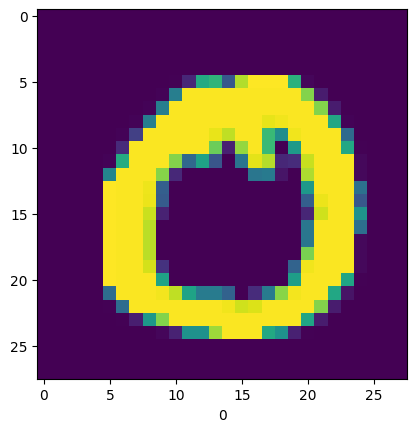

In [5]:
import matplotlib.pyplot as plt
data = next(iter(train_data))
imgs = data[0]
labels = data[1]
img = imgs[0].permute(1, 2, 0)
plt.imshow(img)
plt.xlabel(labels[0].item())

In [6]:
class CNN_classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1)
    self.dense1 = nn.Linear(7*7*128, 10)
    self.act = nn.LeakyReLU(0.2)
    self.regularize = nn.Dropout(0.3)
  def forward(self, x):
    x = self.conv1(x)
    x = nn.MaxPool2d(2)(x)
    x = self.act(x)
    x = self.conv2(x)
    x = nn.MaxPool2d(2)(x)
    x = self.act(x)
    x = x.view((x.shape[0], -1))
    x = self.regularize(x)
    x = self.dense1(x)

    return nn.functional.log_softmax(x, dim=1)

def test():
  x = torch.randn((5, 1, 28, 28))
  classifier = CNN_classifier()
  output = classifier.forward(x)
  print(output)

test()

tensor([[-2.0054, -2.5018, -2.5188, -2.5131, -2.1451, -2.5264, -2.3435, -2.3292,
         -2.0879, -2.2297],
        [-2.1004, -2.6882, -2.6063, -2.2631, -2.3186, -2.5993, -2.1951, -2.2157,
         -1.9705, -2.3106],
        [-2.3905, -2.3578, -2.5749, -2.2312, -1.9073, -2.7126, -2.6499, -2.0386,
         -2.3507, -2.1268],
        [-2.1971, -2.7424, -2.6134, -2.3398, -1.8508, -2.4454, -2.3396, -2.1197,
         -2.3793, -2.2829],
        [-2.3443, -2.4689, -2.3841, -2.3720, -2.4554, -2.3153, -2.2042, -2.3585,
         -2.0773, -2.1268]], grad_fn=<LogSoftmaxBackward0>)


In [7]:
from tqdm import tqdm
classifier = CNN_classifier().to('cuda')
optimizer = torch.optim.Adam(classifier.parameters(), lr = 1e-4)

def train(epoch):
  classifier.train()
  for batch_idx, (features, labels) in tqdm(enumerate(train_data)):
    optimizer.zero_grad()
    output = classifier(features.to('cuda'))
    loss = nn.functional.nll_loss(output, labels.to('cuda'))
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_data.dataset)))
      torch.save(classifier.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')


In [8]:
def test():
  classifier.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_data:
      output = classifier(data.to('cuda'))
      output = output.to('cpu')
      test_loss += nn.functional.nll_loss(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_data.dataset)
  test_losses.append(test_loss)

In [9]:
train_losses = []
train_counter = []
test_losses = []
n_epochs = 9
log_interval = 9
test_counter = [i*len(train_data.dataset) for i in range(n_epochs+1)]

for epoch in range(n_epochs):
  train(epoch)
  test()

15000it [01:08, 220.47it/s]
15000it [01:06, 227.02it/s]
15000it [01:06, 224.96it/s]
15000it [01:06, 225.97it/s]
15000it [01:06, 225.33it/s]
15000it [01:05, 229.20it/s]
15000it [01:06, 226.32it/s]
15000it [01:06, 224.83it/s]
15000it [01:05, 230.35it/s]
15000it [01:05, 229.82it/s]


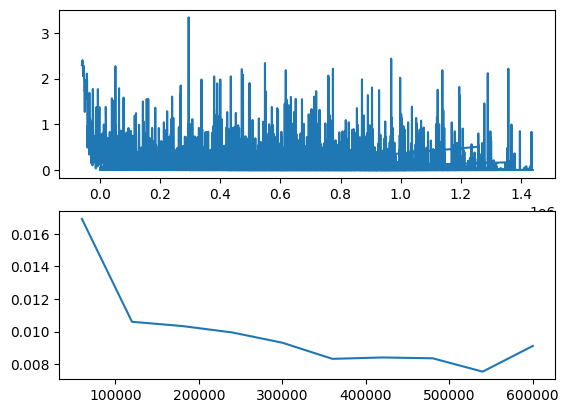

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2)
axs[0].plot(train_counter, train_losses)


axs[1].plot(test_counter[1:], test_losses)
plt.show()


Text(0.5, 0, '4')

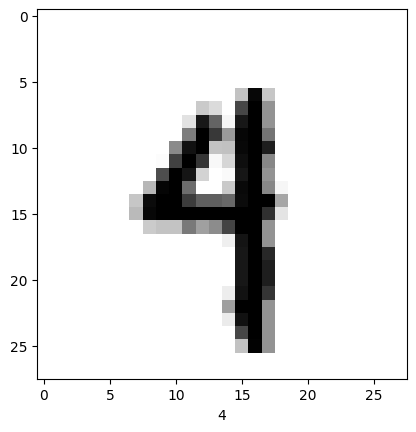

In [11]:
test = next(iter(test_data))
img_test = test[0][0].view((1, 1, 28, 28))
label_test = test[1][0]
output = classifier(img_test.to('cuda'))
img_test = img_test[0].permute((1, 2, 0))
plt.imshow(img_test, cmap=plt.cm.binary)
plt.xlabel(torch.argmax(output).item())

In [12]:
accuracy = []

for idx, (features, labels) in enumerate(test_data):
  output=classifier(features.to('cuda'))
  output = output.to('cpu')
  for i in range(len(output)):
    if torch.argmax(output[i]) == labels[i]:
      accuracy.append(1)
    else:
      accuracy.append(0)
print(sum(accuracy)/ len(accuracy))

0.9885


In [13]:
import numpy as np
import pandas as pd
dataframe = pd.read_csv('test.csv', header=0).to_numpy().astype(np.float32)
dataframe = torch.from_numpy(dataframe).view(dataframe.shape[0], 1, 28, 28)
print(dataframe.shape)

torch.Size([28000, 1, 28, 28])


In [14]:
output = classifier(dataframe.to('cuda'))
output = output.to('cpu')
print(output.shape)

torch.Size([28000, 10])


In [19]:
submission = pd.read_csv('sample_submission.csv', header=0).to_numpy()
print(submission)
for i in range(output.shape[0]):
  submission[i][1] = torch.argmax(output[i])
print(submission)

[[    1     0]
 [    2     0]
 [    3     0]
 ...
 [27998     0]
 [27999     0]
 [28000     0]]
[[    1     2]
 [    2     0]
 [    3     9]
 ...
 [27998     3]
 [27999     9]
 [28000     2]]


In [21]:
final_submission = pd.DataFrame(submission, columns = ['ImageId', 'Label'])

In [23]:
print(final_submission.head)

<bound method NDFrame.head of        ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]>


In [24]:
final_submission.to_csv('submission_v05.csv', index = False)